In [1]:
from fastai.text import *
from fastai import *

import pandas as pd
import numpy as np

In [2]:
path = Path('/home/jupyter/insight_project/Project-M/data/preprocessed/csv')
filenames = path.ls()
filenames.remove(Path('/home/jupyter/insight_project/Project-M/data/preprocessed/csv/models'))
len(filenames)

71

In [3]:
import random

random.seed(42)
random.shuffle(filenames)
 
def _train_valid_split(total_filenames,train_pct=0.7):
    '''split the train and test base on total datasets
        return train_list and valid_list with their associated path'''

    split_point = round(len(total_filenames)*train_pct)
    assert (type(split_point) == int)
    return total_filenames[:split_point],total_filenames[split_point:]

def _get_df_from_filenames(filenames):
    '''pass a list of filenames, return df of total'''
    
    dfs = []
    for file in filenames:
        df = pd.read_csv(file)
        dfs.append(df)

    df_total = pd.concat(dfs)
    return df_total

In [4]:
train_list, valid_list = _train_valid_split(filenames)
df_train = _get_df_from_filenames(train_list)
df_train['Label'].value_counts()

0    11599
1     3472
Name: Label, dtype: int64

In [5]:
from pytorch_pretrained_bert import BertTokenizer

bert_tok = BertTokenizer.from_pretrained(
    "bert-base-uncased",
)

In [6]:
class FastaiBertTokenizer(BaseTokenizer):
    '''wrapper for fastai tokenizer'''
    def __init__(self, tokenizer, max_seq=128, **kwargs):
        self._pretrained_tokenizer = tokenizer
        self.max_seq_length = max_seq
        
    def __call__(self,*args,**kwargs):
        return self
    
    def tokenizer(self,t):
        return ["[CLS]"] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_length - 2] + ['[SEP]']

In [7]:
fastai_bert_vocab = Vocab(list(bert_tok.vocab.keys()))

In [8]:
fastai_bert_vocab.itos[2000:2010]

['to', 'was', 'he', 'is', 'as', 'for', 'on', 'with', 'that', 'it']

In [9]:
fastai_tokenizer = Tokenizer(tok_func=FastaiBertTokenizer(bert_tok,max_seq=128),pre_rules=[fix_html],post_rules=[])

In [10]:
processor = [OpenFileProcessor(),
             TokenizeProcessor(tokenizer=fastai_tokenizer,include_bos=False,include_eos=False),
             NumericalizeProcessor(vocab=fastai_bert_vocab)
            ]

In [11]:
from pytorch_pretrained_bert.modeling import BertConfig, BertForSequenceClassification, BertForNextSentencePrediction, BertForMaskedLM
bert_model_class = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model = bert_model_class

In [24]:
def _get_individual_data(filepath):
    df = pd.read_csv(filepath)
    if df.shape[0]*0.7 < 64: 
        bs= int(df.shape[0]*0.7)
    else: bs=64
    data = (TextList
            .from_df(df=df,path=path,cols='Body',vocab=fastai_bert_vocab,processor=processor)
            .split_by_rand_pct(0.3,seed=42)
            .label_from_df(cols='Label')
            .databunch(bs=bs,num_workers=os.cpu_count()*4)
           )
    return data

def _get_individual_learner(data):
    learn = Learner(data, model,
                      model_dir=path/'models', metrics=accuracy
                     )
    if torch.cuda.is_available():
        learn.to_fp16()
    #learn.load('general-clasifier-0.84')
    #learn.freeze_to(-1)
    return learn

def run_valid(data_path):
    _data_valid = _get_individual_data(data_path)
    _learn_valid = _get_individual_learner(_data_valid)
    _learn_valid.fit(2,1e-2)
    return _learn_valid.recorder.metrics[0][0].item()

In [25]:
%%time
valid_acc = []
for file in valid_list:
    valid_acc.append(run_valid(file))

epoch,train_loss,valid_loss,accuracy,time
0,5.999864,1.092111,0.333333,00:01
1,3.597703,5.151484,0.333333,00:01


CPU times: user 1min, sys: 37.6 s, total: 1min 37s
Wall time: 2min 3s


# Bert-base: 1 epoch with cos-scheduler 

In [14]:
valid_acc

[0.9729729890823364,
 0.8235294222831726,
 0.3979591727256775,
 0.25,
 0.8513800501823425,
 0.9864864945411682,
 0.057553958147764206,
 0.18518517911434174,
 0.032258063554763794,
 0.3529411852359772,
 0.4166666865348816,
 0.8571428656578064,
 0.9277777671813965,
 0.8205128312110901,
 0.9365079998970032,
 0.6190476417541504,
 0.9999999403953552,
 0.5625,
 0.5248618721961975,
 0.8285714387893677,
 0.6666666865348816]

In [15]:
np.mean(valid_acc)

0.6224058211914131

# Bertbase: 2 epochs with cos-scheduler

In [18]:
valid_acc

[0.9729729890823364,
 0.8235294222831726,
 0.6020408272743225,
 0.7500000596046448,
 0.8513800501823425,
 0.9864864945411682,
 0.9424460530281067,
 0.8148148059844971,
 0.9677419066429138,
 0.6470588445663452,
 0.5833333730697632,
 0.8571428656578064,
 0.9277777671813965,
 0.8205128312110901,
 0.9365079998970032,
 0.6190476417541504,
 0.9999999403953552,
 0.5625,
 0.5248618721961975,
 0.8285714387893677,
 0.6666666865348816]

In [19]:
np.mean(valid_acc)

0.7945425652322315

# Bertbase 3: 3 epochs with consitant lr

In [22]:
valid_acc

[0.9729729890823364,
 0.8235294222831726,
 0.6020408272743225,
 0.7500000596046448,
 0.8513800501823425,
 0.9864864945411682,
 0.9424460530281067,
 0.8148148059844971,
 0.032258063554763794,
 0.6470588445663452,
 0.4166666865348816,
 0.8571428656578064,
 0.9277777671813965,
 0.8205128312110901,
 0.0634920671582222,
 0.6190476417541504,
 0.9999999403953552,
 0.5625,
 0.4751381278038025,
 0.8285714387893677,
 0.6666666865348816]

In [23]:
np.mean(valid_acc)

0.6981192220534597

# Bertbase 4: 2 epochs with consistant lr

In [26]:
valid_acc

[0.027027027681469917,
 0.1764705926179886,
 0.6020408272743225,
 0.7500000596046448,
 0.8513800501823425,
 0.9864864945411682,
 0.9424460530281067,
 0.8148148059844971,
 0.9677419066429138,
 0.3529411852359772,
 0.4166666865348816,
 0.1428571492433548,
 0.9277777671813965,
 0.8205128312110901,
 0.0634920671582222,
 0.380952388048172,
 0.9999999403953552,
 0.5625,
 0.5248618721961975,
 0.8285714387893677,
 0.3333333432674408]

In [27]:
np.mean(valid_acc)

0.5939464041342338

In [28]:
result = [0.5939464041342338,0.6981192220534597, 0.6224058211914131,0.7945425652322315]

Text(0, 0.5, 'Accuracy')

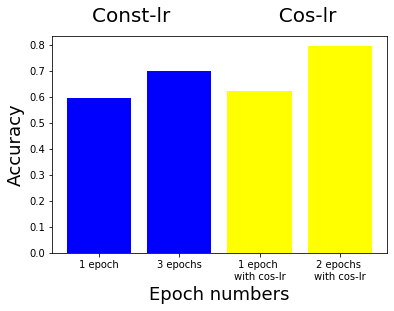

In [59]:
fig = plt.figure()
plt.bar(['1 epoch','3 epochs','1 epoch \nwith cos-lr','2 epochs \nwith cos-lr'],result,color=['blue','blue','yellow','yellow'])
fig.suptitle('Const-lr                 Cos-lr', fontsize=20)
plt.xlabel('Epoch numbers', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
# ax.set(xlabel='Experiment', ylabel='Accuracy')
# ax.show()